In [5]:
import ezbci_lite as ezbci
import numpy as np
import matplotlib.pyplot as plt
import pyxdf

In [6]:
fname = 'D:\\Users\\H8801\\EEG_Bootcamp_Repo\\data\\Photosensor\\SimplePhotosensorTest.xdf'
streams, fileheader = pyxdf.load_xdf(fname)

Stream 2: Calculated effective sampling rate 121.0071 Hz is different from specified rate 250.0000 Hz.


(500.0, 1000.0)

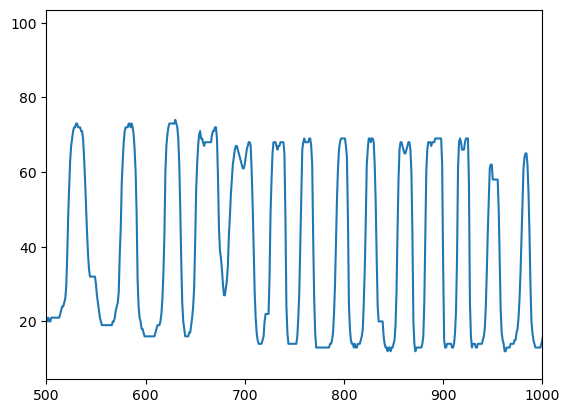

In [12]:
plt.plot(streams[0]['time_series'][:, 0])
plt.xlim([500, 1000])